<a href="https://colab.research.google.com/github/kodiakpony/datakit-housing-fall-2024/blob/main/DataKindChallenge3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intro and Background


*   DataKind Housing challenge
*   Challenge 3, "Getting Started" analysis
*   Used EODataScape data (with different names than data dictionary, augmented by the following other datasets (for population, and visualization)
* Add links to datasets/data dictionaries
* note geoids 11 digit STATE+COUNTY+TRACTID. add link to geoids page
*   Also wanted to use CDFI dataset to get more granular info, but it is using 2010 census ids. Is still very interesting. S  ee separate analysis
*   Analysis done in Goolge Colab, using Pandas, Seaborn.  
* Also have a Folium map (in this doc or elsewhere?

* Key takeaways??
* TODO: also create README in GitHub



## Setup

Import libraries, read in datasets


In [1]:
# import libraries

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles, layout
import seaborn as sns
import zipfile
import requests, io
#import plotly.express as px

import numpy as np
#import contextily as ctx
import geopandas as gpd
#import os
#import folium
from mpl_toolkits.axes_grid1 import make_axes_locatable

Reading in the v1.1 Florida dataset, with > 5000 rows, since the v1 dataset had < 2000. Note however that the column names are different in the v1.1 dataset and not consistent with the EODatascape data dictionary. It is generally obvious from the column names which ones they correspond to.

Also, add a boolean column indicating non-negigible CDFI lending, and a column indicating which set of government programs a Census tract belongs to (CDFI Investment Areas, HUD Qualified Census Tract, HUD Opportunity Zone)

In [27]:
# Read DataKind EODataScape housing dataset into Panda dataframe df

version=1.1
url = f"https://github.com/datakind/datakit-housing-fall-2024/releases/download/v{version}/housing-data.zip"
#url = 'https://github.com/datakind/datakit-housing-fall-2024/releases/download/v1.1/housing-data.zip'
#url = 'https://github.com/datakind/datakit-housing-fall-2024/releases/download/v1.0/housing-data.zip
filename = "housing-data/FL/data_1-FL.csv"

r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open(filename) as myfile:
        df = pd.read_csv(myfile)

# rename some columns because the original dataset used different names than the current one and I don't want to change everything
# don't do renaming if using the v1.0 dataset
if(version==1.1):
  column_renames={
      "hud_opportunity_zones" : "opzone",
      "cdfi_fund_invest_areas" : "investment_areas",
      "lihtc_qualified_tracts" : "qct",
      "cdfi_fund_economic_distress" : "economic_distress_pop_agg",
      "county" : "county_name",
      "county_fips_code" : "county",
      "haz_waste_supp_pctile" : "haz_waste_prox_supp_pctile"
  }
  df=df.rename(columns=column_renames)

# add a boolean column for whether a census tract has non-negligible CDFI lending
df["has_cdfi_lending"]=df.total_cdfi_lending.apply(lambda x: x>10000)

# make "cdfi_fund_invest_areas" a clone of "investment_areas"
df["cdfi_fund_invest_areas"]=df.investment_areas

# change "investment_areas" from YES/NO to 1/0,
df["investment_areas"]=df.investment_areas.apply(lambda x: 1 if x=="YES" else 0)

#  add a column indicating which set of government programs a Census tract belongs to (CDFI Investment Areas, HUD Qualified Census Tract, HUD Opportunity Zone)
#  values are like "101", "010" etc indicating membership in investment_areas, opzone, and qct by digit
df["venn_key"]=df.apply(lambda x: str(x.investment_areas)[0]+str(x.opzone)[0]+str(x.qct)[0],axis=1)

# make a human friendly version of that column, combining the rare values, to be used for pie charts
df["overlap_label"]=df.venn_key.map({
    "000":"none",
    "100":"ia",
    "101":"ia+qct",
    "111":"all",
    "110":"ia+op",
    "011":"other",
    "010":"other",
    "001":"other"
})

# add a similar column combinining investment_areas, has_cdfi_lending, and economic_distress
df["venn_ia_hl_ed"]=df.apply(lambda x: str(x.investment_areas)[0]+str("1" if x.has_cdfi_lending else "0")[0]+str("1" if x.economic_distress_pop_agg=="YES" else "0")[0],axis=1)

# drop rows for which total_cdfi_lending or num_mortgages_origin is not defined
display(f"dropping rows with missing total_cdfi_lending: {df.total_cdfi_lending.isna().sum()}")
display(f"dropping rows with missing num_mortgages_origin: {df.num_mortgages_origin.isna().sum()}")
df.dropna(subset=["num_mortgages_origin","total_cdfi_lending"],inplace=True)

# set percentile columns for cdfi lending and num mortages originated
df["pctile_cdfi_lending_fl"]=df.total_cdfi_lending.rank(pct=True)
df["pctile_mortgages_origin_fl"]=df.num_mortgages_origin.rank(pct=True)

df.head().T

'dropping rows with missing total_cdfi_lending: 124'

'dropping rows with missing num_mortgages_origin: 83'

,0,1,2,3,4
geoid,12001000600,12001000809,12001001100,12001001202,12001001519
geoid_year,2020,2020,2020,2020,2020
state,Florida,Florida,Florida,Florida,Florida
county_name,Alachua County,Alachua County,Alachua County,Alachua County,Alachua County
state_fips_code,12,12,12,12,12
...,...,...,...,...,...
venn_key,111,101,000,000,101
overlap_label,all,ia+qct,none,none,ia+qct
venn_ia_hl_ed,111,101,010,010,111
pctile_cdfi_lending_fl,0.173818,0.009679,0.209339,0.996208,0.121333


Read in the other dataset (add info!) from census.gov with population and number of households per census tract, and merge into main dataframe

In [28]:
# read in the dataset downloaded from census.gov, which has population and number of households per census tract

url="https://raw.githubusercontent.com/kodiakpony/datakit-housing-fall-2024/refs/heads/main/challenge-3/FL/DECENNIALDP2020.DP1_2024-10-12T222820/DECENNIALDP2020.DP1-Data.csv"

population_df_columns={
    "GEO_ID":"full_geoid",
    "NAME":"full_name",
    "DP1_0001C":"total_population",
    "DP1_0132C":"total_households"
}

# the first two rows of the dataset are column descriptions and Florida-wide totals. Extract these and then drop them from dataframe
dfpop = pd.read_csv(url).loc[:,[*population_df_columns]].rename(columns=population_df_columns)
pop_descriptions=dfpop.iloc[0]
pop_florida_totals = dfpop.iloc[1]
dfpop.drop([0,1],inplace=True)

# make population and households columns numeric, now we've dropped the descriptions row
dfpop.total_population=dfpop.total_population.astype(int)
dfpop.total_households=dfpop.total_households.astype(int)

# the dataset uses fully qualified geoids that encode country, with format:
# 1400000US12001000201
# we just want the last 11 digits for consistency with other dataset
dfpop["geoid"]=dfpop["full_geoid"].apply(lambda x: x.split("US")[1]).astype(int)

display("census population dataset: ",dfpop.head())

# merge into main dataframe
display("merging population totals data into main dataframe")
display("dfpop shape:",dfpop.shape, "df shape: ",df.shape)
df=df.merge(dfpop,on="geoid",how="left")
display("merged df shape: ", df.shape)

<ipython-input-28-0f9b946fa872>:13: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  dfpop = pd.read_csv(url).loc[:,[*population_df_columns]].rename(columns=population_df_columns)


'census population dataset: '

,full_geoid,full_name,total_population,total_households,geoid
2,1400000US12001000201,Census Tract 2.01; Alachua County; Florida,4348,1711,12001000201
3,1400000US12001000202,Census Tract 2.02; Alachua County; Florida,4782,1695,12001000202
4,1400000US12001000301,Census Tract 3.01; Alachua County; Florida,3384,1808,12001000301
5,1400000US12001000302,Census Tract 3.02; Alachua County; Florida,2644,1257,12001000302
6,1400000US12001000400,Census Tract 4; Alachua County; Florida,5330,2117,12001000400


'merging population totals data into main dataframe'

'dfpop shape:'

(5160, 5)

'df shape: '

(5011, 391)

'merged df shape: '

(5011, 395)

## Number of Mortgages and Total CDFI Lending

First we look at two of the variables called out in the challenge, the number of mortgages and total cdfi lending per census tract.

Num_mortgages_origin is column ?? in the EODataScape dataset, and comes from ??.
It looks like these is all mortgages that get originated in the census tract, regardless of whether there was any CDFI or government funding assistance.

Total_cdfi_lending is column ??, and comes from ??. The source dataset has much more granular information, including funding for home purchases vs businesses vs construction, the size of individual loans, demographics about the loan recipient (income level, race etc), and the CDFI that originated the loan. The source dataset uses 2010 census tract ids whereas EODataScape uses 2020 census ids, so there must have been some remapping done to get total_cdfi_lending for EODataScape.

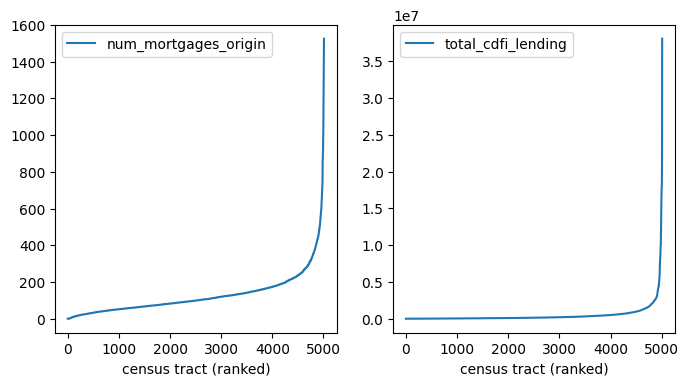

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8,4))

df.num_mortgages_origin.sort_values(ascending=True).reset_index().plot(y="num_mortgages_origin",ax=axes[0],xlabel="census tract (ranked)")

df.total_cdfi_lending.sort_values(ascending=True).reset_index().plot(y="total_cdfi_lending",ax=axes[1],xlabel="census tract (ranked)")

plt.show()

**Discussion**

In the above plots we can see the extreme tail values for each of these variables. The vast majority of the census tracts have < 200 mortgages originated but some have over 1400. For total CDFI lending the tail is even more extreme, with almost all having less than \$2 million in spending but some having over \$35 million.

This means that care must be taken when looking at how total CDFI lending and mortgages are apportioned amongst different categories of census tracts, since a small percentage of census tracts can skew the results significantly. Rather than the sum of CDFI funding across a category, it may be more useful to look at histograms, scatterplots or percentiles. Or to exclude the outlier values from the aggregation.

The query below shows that 27% of total CDFI funding for the state of Florida goes to 1% of census tracts (and 7% of mortgages are originated in 1% of census tracts)



In [ ]:
q=df.loc[:,["num_mortgages_origin","total_cdfi_lending"]].quantile([0.5,0.95,0.96,0.97,0.98,0.99])

percent_cdfi_funding_in_top_1_percent = df.total_cdfi_lending[df.total_cdfi_lending>=q.loc[0.99,"total_cdfi_lending"]].sum()*100/df.total_cdfi_lending.sum()

percent_mortgages_in_top_1_percent = df.num_mortgages_origin[df.num_mortgages_origin>=q.loc[0.99,"num_mortgages_origin"]].sum()*100/df.num_mortgages_origin.sum()

print(
    "percentage of total containted in the top 1% of census tracts:\n",
    f"num_mortgages: {percent_mortgages_in_top_1_percent:0.1f}%\n",
    f"CDFI funding: {percent_cdfi_funding_in_top_1_percent:0.1f}%"
    )

percentage of total containted in the top 1% of census tracts:
 num_mortgages: 7.2%
 CDFI funding: 27.4%


The other obvious question from the above graphs is what is causing the tail, and whether it has anything to do with population. It makes intuitive sense that census tracts with larger numbers of households would have more mortgages and potentially more CDFI funding (depending on need).

So let's look at a scatter plot of number of households vs number of originated mortages per census tract.

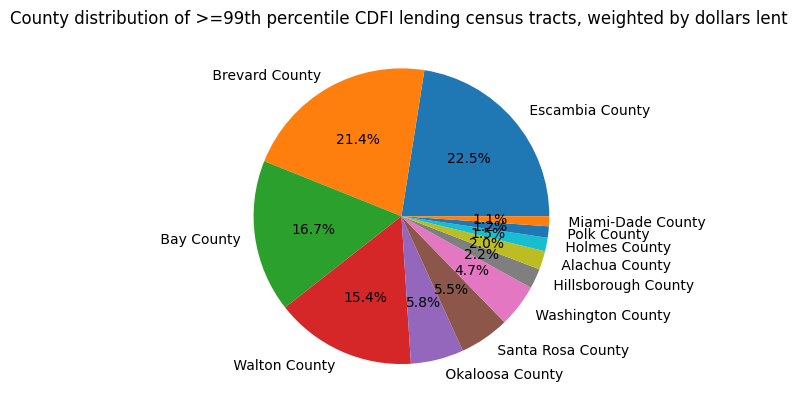

99th percentile census tract CDFI lending is $6.1 million
These tracts get 27.4% of overall CDFI lending for the state of Florida


In [ ]:
top_pct_cutoff=df.loc[:,"total_cdfi_lending"].quantile([0.99]).loc[0.99]
cdf=df.loc[df.total_cdfi_lending>top_pct_cutoff,["total_population","total_cdfi_lending","county_name"]].groupby("county_name").sum().sort_values("total_cdfi_lending",ascending=False)
#percent_cdfi_funding_in_top_1_percent = df.total_cdfi_lending[df.total_cdfi_lending>=q.loc[0.99,"total_cdfi_lending"]].sum()*100/df.total_cdfi_lending.sum()

fig, ax = plt.subplots()

plt.pie(cdf.total_cdfi_lending,autopct='%1.1f%%',labels=cdf.index)
#venn3(a["total_households"].apply(lambda x: x/1000).to_dict(),set_labels=labels,ax=ax)
plt.title("County distribution of >=99th percentile CDFI lending census tracts, weighted by dollars lent ")
plt.show()
print(f"99th percentile census tract CDFI lending is ${top_pct_cutoff/1000000:.1f} million")
print(f"These tracts get {percent_cdfi_funding_in_top_1_percent:0.1f}% of overall CDFI lending for the state of Florida")

We see that four counties get the bulk of this top 1% lending (and so account for >20% of total CDFI lending just from their top 1% census tracts alone). Interesting because many CDFIs are regional and may help us figure out which ones are making these big loans?  (since couldn't convert org_id in other dataset). **TODO:** add link to page with list of Florida CDFIs  
**TODO:** move this up?

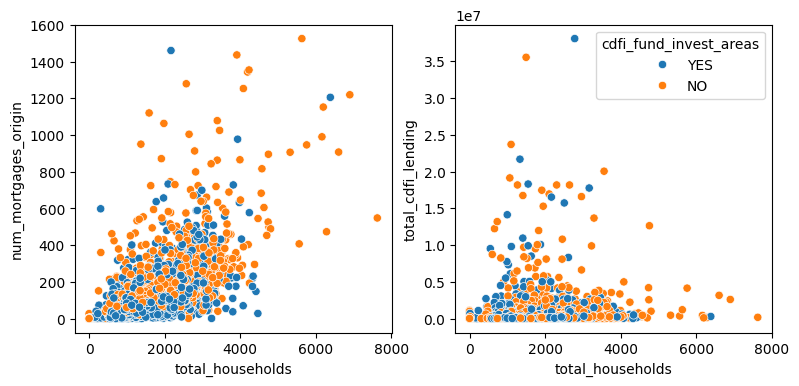

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

sns.scatterplot(data=df,x="total_households",y="num_mortgages_origin",hue="cdfi_fund_invest_areas",ax=axes[0],legend=False)

sns.scatterplot(df,x="total_households",y="total_cdfi_lending",hue="cdfi_fund_invest_areas",ax=axes[1])

plt.show()

**Discussion**

Differing census tracts populations do not appear to be driving the high tail values for number of mortgages or CDFI lending.

Above we some assocation between number of households and number of mortgages, but there are plenty of outliers with moderate numbers of households but large numbers of mortgages. The tracts with > 800 mortgages orginated are overwhelmingly not CDFI fund investment areas.

For CDFI lending, the results are even more extreme. Interestingly, the large values for CDFI lending are almost entirely in tracts with < 4000 households, and are a mix of CDFI fund investment areas and non-investment areas. The census tracts with > 4000 households tend not to be CDFI fund investment areas and have low to modest amounts of CDFI lending.  

**TODO** clean this up
Arguably should be looking at needy households for CDFI lending, but the blue dots should be census tracts with needy populations



<Axes: xlabel='num_mortgages_origin', ylabel='total_cdfi_lending'>

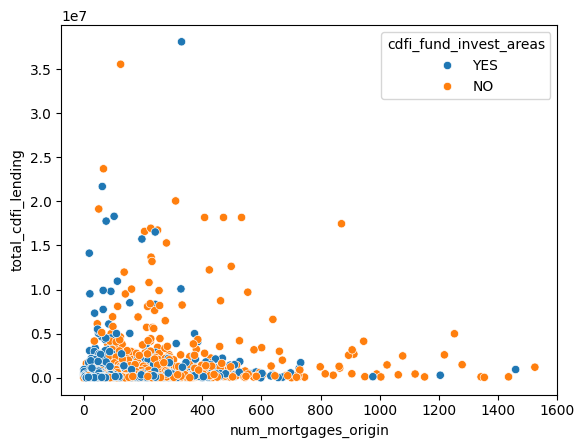

In [ ]:
sns.scatterplot(df,x="num_mortgages_origin",y="total_cdfi_lending",hue="cdfi_fund_invest_areas")

**TODO: ADD DISCUSSION AND MOVE THIS BEFORE THE OTHER SCATTERPLOTS**

This seems to show that CDFI lending in investment_areas doesn't help with number of mortgages!  All the investment areas with a high number of mortgages have very low CDFI lending, and those with high amounts of lending have a low to modest number of mortgages originated.

Talk about different CDFI lending things besides home mortgages etc

## Government program overlaps

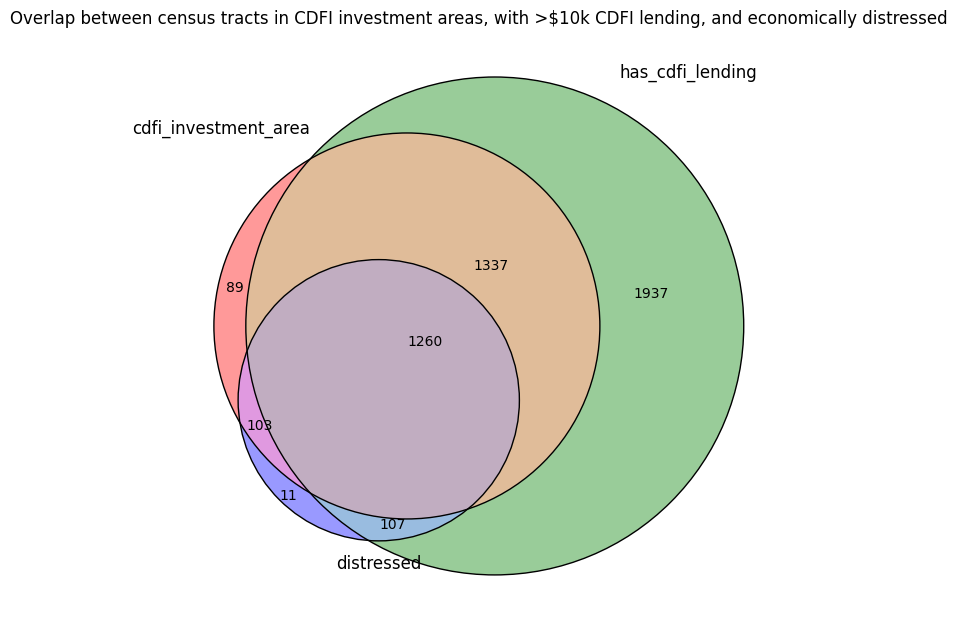

'\nvenn3(\n    df.loc[:,["venn_key2","total_population"]].groupby("venn_key2").sum()["total_population"].to_dict(),\n    subset_label_formatter=lambda x: f"{x/1000:,.1f}k",\n    set_labels=labels,\n    ax=axes[1]\n)\n'

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
labels=["cdfi_investment_area","has_cdfi_lending","distressed"]
venn3(
    df.loc[:,["venn_ia_hl_ed","geoid"]].groupby("venn_ia_hl_ed").count()["geoid"].to_dict(),
    set_labels=labels,
#    ax=axes[0]
)

venn3_circles(
    df.loc[:,["venn_ia_hl_ed","geoid"]].groupby("venn_ia_hl_ed").count()["geoid"].to_dict(),
    linewidth=1
)

plt.title("Overlap between census tracts in CDFI investment areas, with >\$10k CDFI lending, and economically distressed")
plt.show()
"""
venn3(
    df.loc[:,["venn_key2","total_population"]].groupby("venn_key2").sum()["total_population"].to_dict(),
    subset_label_formatter=lambda x: f"{x/1000:,.1f}k",
    set_labels=labels,
    ax=axes[1]
)
"""

In [ ]:
df[df.venn_ia_hl_ed == "001"].loc[:,[
    "geoid","county_name","investment_areas","opzone","qct","total_population","total_cdfi_lending"]
                                  ].sort_values("county_name")

,geoid,county_name,investment_areas,opzone,qct,total_population,total_cdfi_lending
1309,12011031102,Broward County,0,0,0,3769,2861.000000
1311,12011040101,Broward County,0,0,0,1256,2029.715902
1313,12011040506,Broward County,0,0,0,2201,7912.621990
3855,12011020211,Broward County,0,0,1,2419,7031.000000
3987,12021010111,Collier County,0,0,0,2326,4134.666667
4001,12021010520,Collier County,0,0,0,2151,322.222691
3030,12073001803,Leon County,0,0,0,811,2669.813384
637,12086006706,Miami-Dade County,0,0,0,2404,1247.000000
1893,12086007607,Miami-Dade County,0,0,0,2500,4322.500000
3290,12087971900,Monroe County,0,0,0,7028,3261.000000


Discussion

CDFI public viewer.  Looking at geoid 12011031102, not qualified due to either poverty rate (is < 20%), median family income, unemployment rate or population loss rate

https://cimsprodprep.cdfifund.gov/CIMS4/apps/pn-cdfi/index.aspx#?entity=CT_2020_CDFI,12011031102&center=-80.096433,26.241096&level=14&visible=CT_2020_CDFI

What makes economically distressed?  Here is what data dictionary says for CDFI fund areas of economic distress
https://eodatascape.datakind.org/data-dictionary
According to the data dictionary, it comes from 2024 data, whereas the investment_areas and cdfi lending fields come from 2021 data, so this could be be a data consistency issue (the area is distressed in 2024 but was not in 2021).  I'm not sure what year the data CDFI public viewer is using.

Looking at the source dataset for areas of economic distress, that geoid is non-rural, is a FY2024 CMF area of economic distress, but not a FY2024 low income area. I'm not entirely sure what the distinction is.


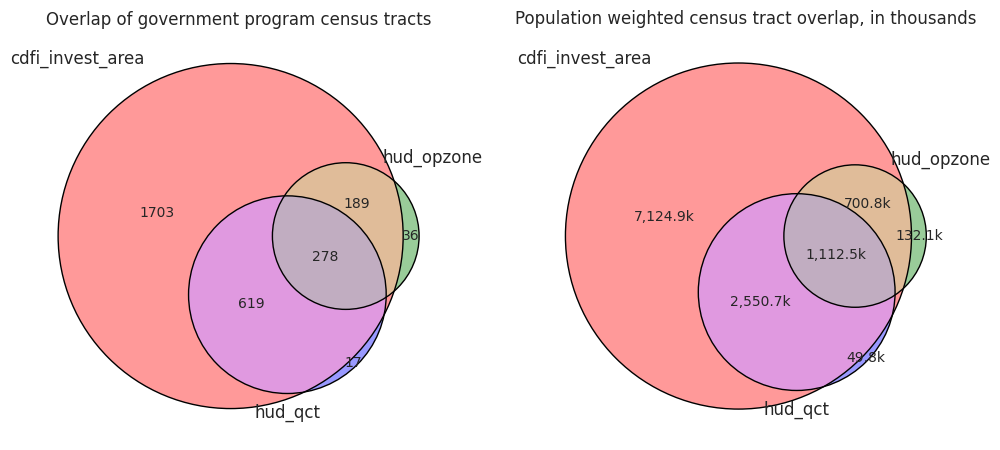

In [ ]:
labels=["cdfi_invest_area","hud_opzone","hud_qct"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

d=df.loc[:,["venn_key","total_population"]].groupby("venn_key").count()["total_population"].to_dict()
ax=axes[0]

venn3(d, set_labels=labels, ax=ax)
venn3_circles(d, linewidth=1, ax=ax)
ax.set_title("Overlap of government program census tracts")

d=df.loc[:,["venn_key","total_population"]].groupby("venn_key").sum()["total_population"].to_dict()
ax=axes[1]

venn3(d, set_labels=labels, subset_label_formatter=lambda x: f"{x/1000:,.1f}k", ax=ax)
venn3_circles(d, linewidth=1, ax=ax)
ax.set_title("Population weighted census tract overlap, in thousands")

plt.show()




discussion.  Yep overlap.  weighting by population doesn't change much

make pie plots of num mortgages and non-tail cdfi lending and households

In [41]:
df.total_cdfi_lending.quantile([0.9,0.95,0.97,0.99])

,total_cdfi_lending
0.90,9.739870e+05
0.95,1.707254e+06
0.97,2.485657e+06
0.99,6.064774e+06


<ipython-input-42-f10195235d38>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  a.plot.pie(subplots=True,autopct='%1.0f%%',legend=False,ax=ax)


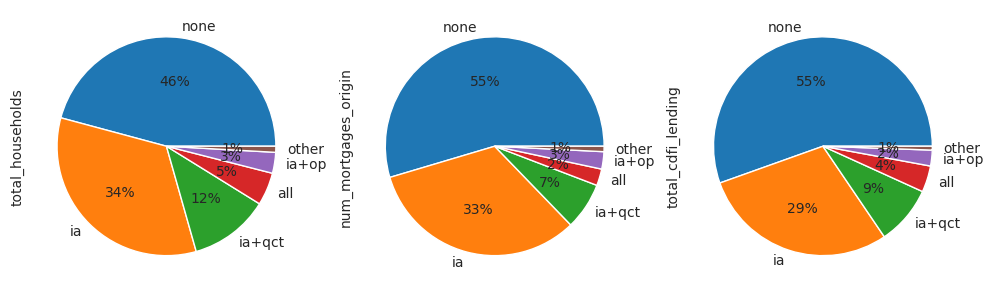

array([<Axes: ylabel='total_households'>,
       <Axes: ylabel='num_mortgages_origin'>,
       <Axes: ylabel='total_cdfi_lending'>], dtype=object)

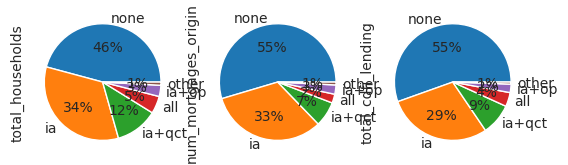

In [42]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

a=df.loc[:,["overlap_label","total_households","num_mortgages_origin","total_cdfi_lending"]].groupby("overlap_label").sum()
a=a.sort_values("total_households",ascending=False)

a.plot.pie(subplots=True,autopct='%1.0f%%',legend=False,ax=ax)
plt.show()
a.plot.pie(subplots=True,autopct='%1.0f%%',legend=False)

([<matplotlib.patches.Wedge at 0x7ea20367bf40>,
 [Text(0.18735300220235948, 1.0839275125974812, 'none'),
  Text(-0.8299304869876099, -0.7219524823480482, 'ia'),
  Text(0.59218798965425, -0.9269915775826975, 'ia+qct'),
  Text(0.985771530168136, -0.48811319415681836, 'all'),
  Text(1.0845876459931116, -0.18349288312934905, 'ia+op'),
  Text(1.0996157132936175, -0.029073752385420523, 'other')],
 [Text(0.10219254665583243, 0.5912331886895351, '44.6%'),
  Text(-0.45268935653869624, -0.3937922630989354, '33.7%'),
  Text(0.32301163072049993, -0.5056317695905622, '11.6%'),
  Text(0.5376935619098923, -0.26624356044917363, '5.6%'),
  Text(0.591593261450788, -0.1000870271614631, '3.7%'),
  Text(0.5997903890692459, -0.015858410392047557, '0.8%')])

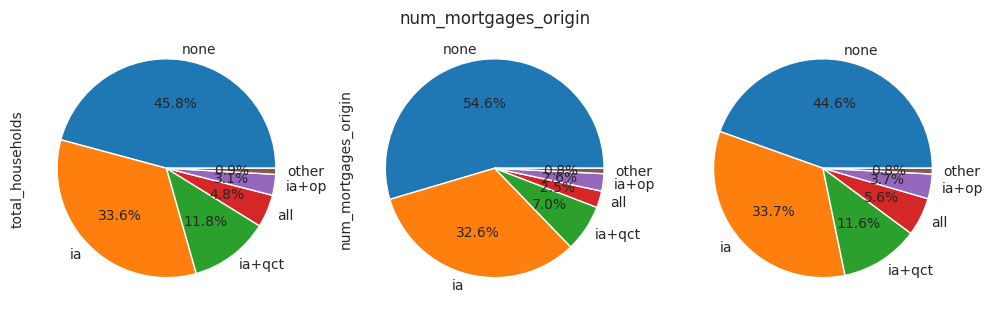

In [29]:

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#labels=["none","cdfi","cdfi+qct","all","cdfi+opzone","other","other","other","other"]
a=df.loc[:,["overlap_label","total_households","num_mortgages_origin"]].groupby("overlap_label").sum()
a=a.sort_values("total_households",ascending=False)

#axes[0].pie(a.total_households,autopct='%1.1f%%',labels=a.index.astype(str))
a.plot.pie(y="total_households",ax=axes[0],autopct='%1.1f%%',labels=a.index,legend=False)

#axes[1].pie(a.num_mortgages_origin,autopct='%1.1f%%',labels=a.index)
a.plot.pie(y="num_mortgages_origin",ax=axes[1],autopct='%1.1f%%',labels=a.index,legend=False)
axes[1].set_title("num_mortgages_origin")

a=df.query("total_cdfi_lending<1000000").loc[:,["overlap_label","total_households","total_cdfi_lending"]].groupby("overlap_label").sum()
a=a.sort_values("total_households",ascending=False)

axes[2].pie(a.total_cdfi_lending,autopct='%1.1f%%',labels=a.index)

In [ ]:
df.loc[:,["pop_pct_white","total_population","pov_pct_est","pov_white_nh_pct_est"]].head()

,pop_pct_white,total_population,pov_pct_est,pov_white_nh_pct_est
0,2.6,4544,34.6,19.5
1,65.8,1163,33.3,35.6
2,76.4,6596,3.6,4.8
3,72.6,7443,3.6,1.6
4,41.1,2623,49.0,45.0


In [ ]:

display("dropping rows with unknown demographics")
display(df.shape)
df.drop(df[df.pov_white_nh_pct_est<0].index,inplace=True)
df.drop(df[df.pov_pct_est<0].index,inplace=True)
df.drop(df[df.pop_pct_white<0].index,inplace=True)

display(df.shape)

display("adding columns for non-white and poor populations")

df["non_white_population"]=((100-df.pop_pct_white)*df.total_population//100)
df["poor_non_white_population"]=df.apply(
    lambda x: 0 if x.pov_white_nh_pct_est>=x.pov_pct_est else (x.pov_pct_est-x.pov_white_nh_pct_est)*x.total_population/100,
    axis=1)


'dropping rows with unknown demographics'

(5011, 392)

(4988, 392)

'adding columns for non-white and poor populations'

([<matplotlib.patches.Wedge at 0x7e49bc061d20>,
 [Text(0.8196596941239376, 0.7335925202921941, '000'),
  Text(-0.9015246973068106, 0.6302802711063259, '100'),
  Text(-0.3442508580865881, -1.0447446322937717, '101'),
  Text(0.8339853544931136, -0.7172645456810172, '111'),
  Text(1.0817656139646559, -0.19945715440583087, '110'),
  Text(1.0996135368520967, -0.029155952593301723, '010'),
  Text(1.09998279039071, -0.006153116630434831, '001'),
  Text(1.0999999992221126, -4.136849915428096e-05, '011')],
 [Text(0.4470871058857841, 0.40014137470483313, '23.2%'),
  Text(-0.491740743985533, 0.3437892387852686, '34.1%'),
  Text(-0.18777319531995712, -0.5698607085238754, '25.2%'),
  Text(0.4549011024507892, -0.3912352067351002, '12.3%'),
  Text(0.5900539712534486, -0.10879481149408955, '4.5%'),
  Text(0.5997892019193254, -0.015903246869073663, '0.5%'),
  Text(0.5999906129403871, -0.0033562454347826347, '0.2%'),
  Text(0.5999999995756976, -2.2564635902335064e-05, '0.0%')])

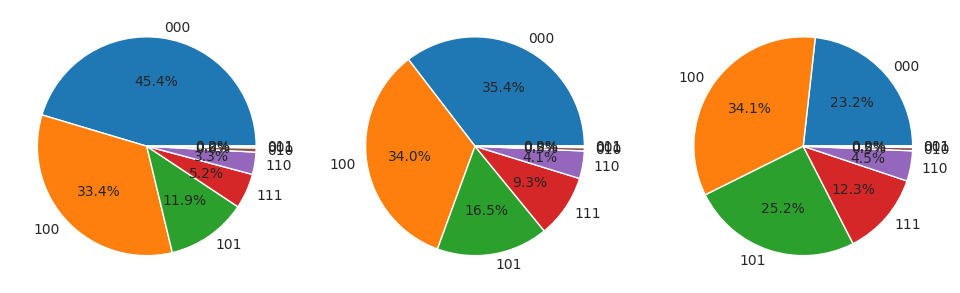

In [ ]:

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

a=df.loc[:,["venn_key","total_population","non_white_population","poor_non_white_population"]].groupby("venn_key").sum()
a=a.sort_values("total_population",ascending=False)

axes[0].pie(a.total_population,autopct='%1.1f%%',labels=a.index.astype(str))

axes[1].pie(a.non_white_population,autopct='%1.1f%%',labels=a.index.astype(str))

axes[2].pie(a.poor_non_white_population,autopct='%1.1f%%',labels=a.index.astype(str))

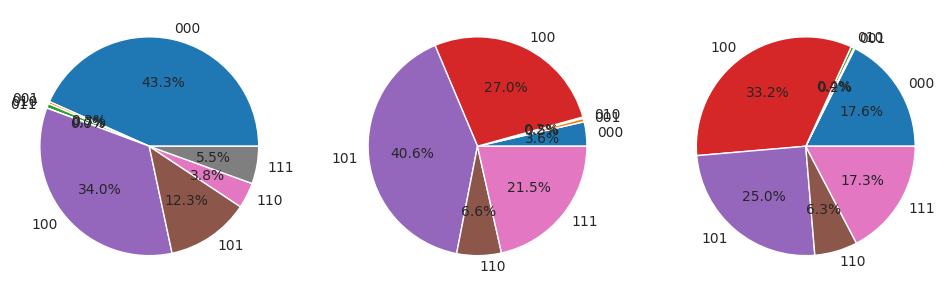

In [ ]:

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i,qstr in enumerate(["pop_pct_white>=0","pov_pct_est>=20","pop_pct_white<=50"]):
  a=df.query(qstr).loc[:,["venn_key","total_population"]].groupby("venn_key").count() #.sort_values("total_population",ascending=False)
  axes[i].pie(a.total_population,autopct='%1.1f%%',labels=a.index.astype(str))


<Axes: xlabel='pov_pct_est', ylabel='num_mortgages_origin'>

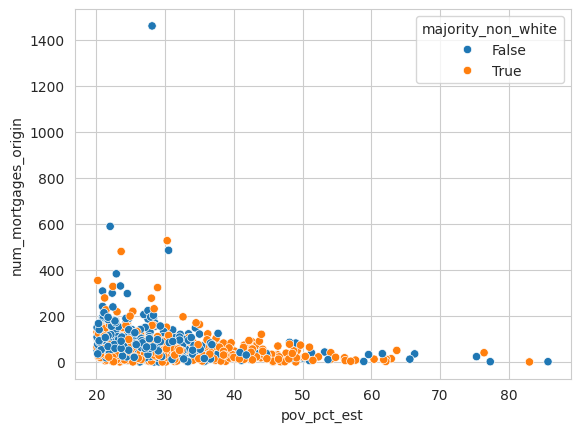

In [ ]:
df["majority_non_white"]=df.pop_pct_white.apply(lambda x: x<50)
sns.scatterplot(df.query("pov_pct_est>20"),x="pov_pct_est",y="num_mortgages_origin",hue="majority_non_white")

Text(0.5, 1.0, 'Tracts with high poverty rate')

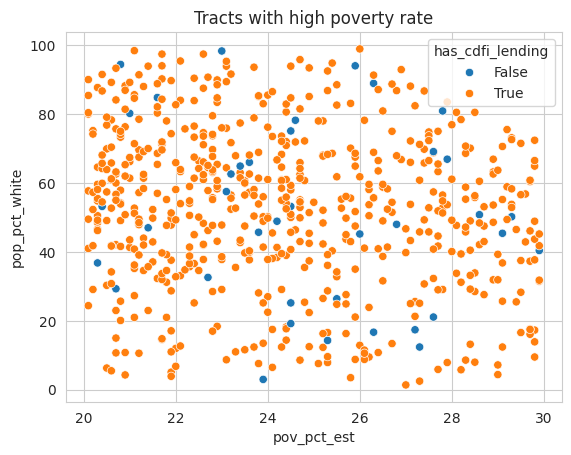

In [ ]:
sns.scatterplot(df.query("pov_pct_est>20 and pov_pct_est<30"),x="pov_pct_est",y="pop_pct_white",hue="has_cdfi_lending") #hue="cdfi_fund_invest_areas")
plt.title("Tracts with high poverty rate")

Text(0.5, 1.0, 'Tracts with negligible CDFI lending')

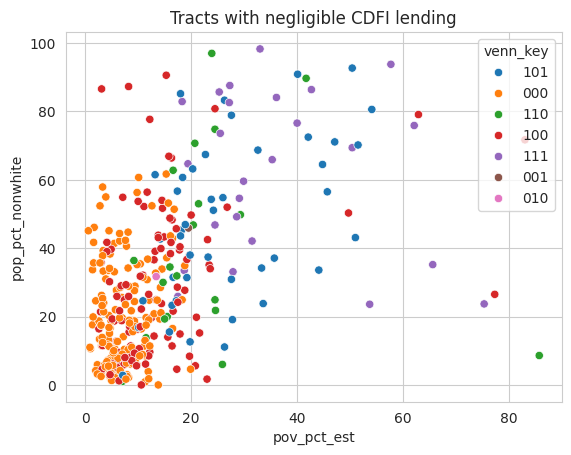

In [ ]:
dtmp["pop_pct_nonwhite"]=100-df.pop_pct_white

#df["pop_pct_nonwhite"]=100-df.pop_pct_white
sns.scatterplot(df[df.has_cdfi_lending==0],x="pov_pct_est",y="pop_pct_nonwhite",hue="venn_key") #hue="cdfi_fund_invest_areas")
plt.title("Tracts with negligible CDFI lending")

<Axes: xlabel='pov_pct_est', ylabel='pctile_cdfi_lending_fl'>

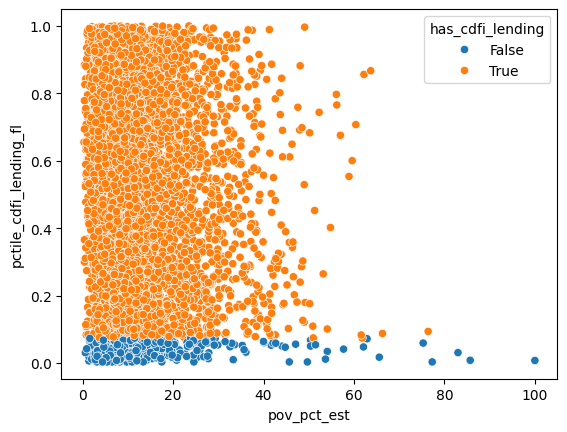

In [ ]:
sns.scatterplot(df[df.pov_pct_est>0],x="pov_pct_est",y="pctile_cdfi_lending_fl",hue="has_cdfi_lending")